In [33]:
import pandas as pd
import glob
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast, TrainingArguments, Trainer, DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as TorchDataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [3]:
!pip install accelerate -U

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU')
else:
    device = torch.device("cpu")
    print('CPU')

GPU


In [35]:
train_paths = ['/content/train/california_wildfires_2018_train.tsv',
               '/content/train/canada_wildfires_2016_train.tsv',
               '/content/train/cyclone_idai_2019_train.tsv',
               '/content/train/ecuador_earthquake_2016_train.tsv',
               '/content/train/greece_wildfires_2018_train.tsv',
               '/content/train/hurricane_dorian_2019_train.tsv',
               '/content/train/hurricane_florence_2018_train.tsv',
               '/content/train/hurricane_harvey_2017_train.tsv',
               '/content/train/hurricane_irma_2017_train.tsv',
               '/content/train/hurricane_maria_2017_train.tsv',
               '/content/train/hurricane_matthew_2016_train.tsv',
               '/content/train/italy_earthquake_aug_2016_train.tsv',
               '/content/train/kaikoura_earthquake_2016_train.tsv',
               '/content/train/kerala_floods_2018_train.tsv',
               '/content/train/maryland_floods_2018_train.tsv',
               '/content/train/midwestern_us_floods_2019_train.tsv',
               '/content/train/pakistan_earthquake_2019_train.tsv',
               '/content/train/puebla_mexico_earthquake_2017_train.tsv',
               '/content/train/srilanka_floods_2017_train.tsv']

val_paths = ['/content/dev/california_wildfires_2018_dev.tsv',
             '/content/dev/canada_wildfires_2016_dev.tsv',
             '/content/dev/cyclone_idai_2019_dev.tsv',
             '/content/dev/ecuador_earthquake_2016_dev.tsv',
             '/content/dev/greece_wildfires_2018_dev.tsv',
             '/content/dev/hurricane_dorian_2019_dev.tsv',
             '/content/dev/hurricane_florence_2018_dev.tsv',
             '/content/dev/hurricane_harvey_2017_dev.tsv',
             '/content/dev/hurricane_irma_2017_dev.tsv',
             '/content/dev/hurricane_maria_2017_dev.tsv',
             '/content/dev/hurricane_matthew_2016_dev.tsv',
             '/content/dev/italy_earthquake_aug_2016_dev.tsv',
             '/content/dev/kaikoura_earthquake_2016_dev.tsv',
             '/content/dev/kerala_floods_2018_dev.tsv',
             '/content/dev/maryland_floods_2018_dev.tsv',
             '/content/dev/midwestern_us_floods_2019_dev.tsv',
             '/content/dev/pakistan_earthquake_2019_dev.tsv',
             '/content/dev/puebla_mexico_earthquake_2017_dev.tsv',
             '/content/dev/srilanka_floods_2017_dev.tsv']

test_paths = ['/content/test/california_wildfires_2018_test.tsv',
              '/content/test/canada_wildfires_2016_test.tsv',
              '/content/test/cyclone_idai_2019_test.tsv',
              '/content/test/ecuador_earthquake_2016_test.tsv',
              '/content/test/greece_wildfires_2018_test.tsv',
              '/content/test/hurricane_dorian_2019_test.tsv',
              '/content/test/hurricane_florence_2018_test.tsv',
              '/content/test/hurricane_harvey_2017_test.tsv',
              '/content/test/hurricane_irma_2017_test.tsv',
              '/content/test/hurricane_maria_2017_test.tsv',
              '/content/test/hurricane_matthew_2016_test.tsv',
              '/content/test/italy_earthquake_aug_2016_test.tsv',
              '/content/test/kaikoura_earthquake_2016_test.tsv',
              '/content/test/kerala_floods_2018_test.tsv',
              '/content/test/maryland_floods_2018_test.tsv',
              '/content/test/midwestern_us_floods_2019_test.tsv',
              '/content/test/pakistan_earthquake_2019_test.tsv',
              '/content/test/puebla_mexico_earthquake_2017_test.tsv',
              '/content/test/srilanka_floods_2017_test.tsv']

train_file_paths = []

for path in train_paths:
    files = glob.glob(path)
    train_file_paths.extend(files)

val_file_paths = []

for path in val_paths:
    files = glob.glob(path)
    val_file_paths.extend(files)

test_file_paths = []

for path in test_paths:
    files = glob.glob(path)
    test_file_paths.extend(files)

In [36]:
train_dfs = []

for file in train_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    train_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True)

val_dfs = [] # dataframes

for file in val_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    val_dfs.append(df)

val_df = pd.concat(val_dfs, ignore_index=True)

test_dfs = [] # dataframes

for file in test_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)

In [37]:
class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()
min_class_size = class_counts.min()  # Size of the smallest class

balanced_dfs = []  # List to hold balanced DataFrames for each class
for class_label in class_labels:
    class_df = train_df[train_df['class_label'] == class_label]
    sampled_df = class_df.sample(n=min_class_size, random_state=42)  # Randomly sample to match smallest class size
    balanced_dfs.append(sampled_df)

train_df = pd.concat(balanced_dfs, ignore_index=True)
# Optional: Shuffle the balanced DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

class_labels = [s.strip() for s in class_labels]

In [38]:
id2label = {id:label for id, label in enumerate(class_labels)}
label2id = {label:id for id, label in enumerate(class_labels)}

In [39]:
all_labels = pd.concat([train_df['class_label'], val_df['class_label'], test_df['class_label']]).unique()

# Create a mapping from class labels to numbers
label_to_num = {label: num for num, label in enumerate(all_labels)}

# Step 2: Apply this mapping to each dataset
train_df['class_label_num'] = train_df['class_label'].map(label_to_num)
val_df['class_label_num'] = val_df['class_label'].map(label_to_num)
test_df['class_label_num'] = test_df['class_label'].map(label_to_num)

<Axes: ylabel='count'>

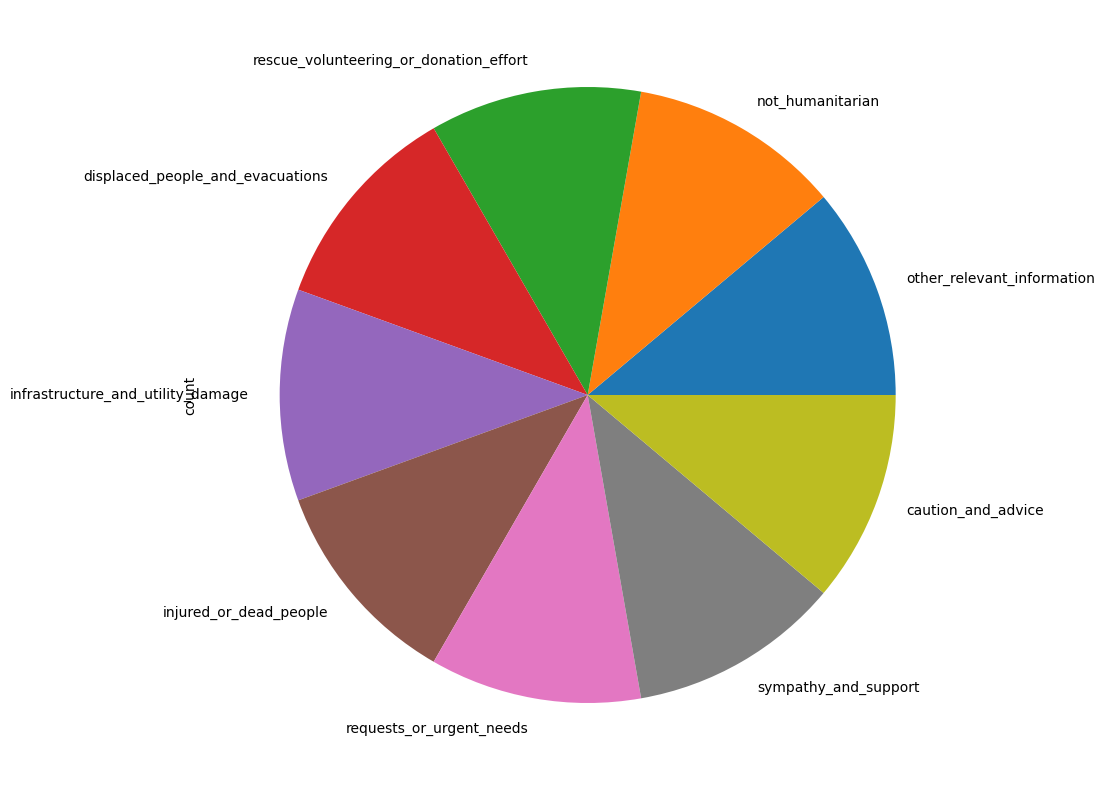

In [40]:
train_df.class_label.value_counts().plot(kind='pie', figsize=(10,10))

In [41]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [42]:
train_tweets = list(train_df.tweet_text)
train_labels = list(train_df.class_label_num)

val_tweets = list(val_df.tweet_text)
val_labels = list(val_df.class_label_num)

test_tweets = list(test_df.tweet_text)
test_labels = list(test_df.class_label_num)

In [43]:
train_encodings = tokenizer(train_tweets, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_tweets, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_tweets, truncation=True, padding=True, max_length=512)

In [44]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [45]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [46]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_to_num))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [47]:
training_args = TrainingArguments(
    output_dir='/content/bert_model_output',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='/content/logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [48]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,2.147200,1.869404,0.439087,0.394769,0.430421,0.439087
200,1.401300,1.030972,0.677324,0.635082,0.676264,0.677324
300,0.924900,0.878638,0.710713,0.694313,0.732271,0.710713
400,0.862200,0.964604,0.687379,0.675825,0.707928,0.687379
500,0.800300,0.932131,0.683254,0.669486,0.734899,0.683254
600,0.752700,0.796548,0.734047,0.723389,0.739847,0.734047
700,0.782100,0.951934,0.671136,0.679896,0.743871,0.671136
800,0.764600,0.829334,0.722186,0.729222,0.756421,0.722186
900,0.767400,0.762836,0.734433,0.720668,0.746867,0.734433
1000,0.733600,0.754819,0.744231,0.738968,0.748165,0.744231


TrainOutput(global_step=3096, training_loss=0.5901627133983051, metrics={'train_runtime': 851.5558, 'train_samples_per_second': 58.118, 'train_steps_per_second': 3.636, 'total_flos': 8520546803884830.0, 'train_loss': 0.5901627133983051, 'epoch': 3.0})

In [49]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 0.7546403408050537,
 'eval_accuracy': 0.7472826086956522,
 'eval_f1': 0.7426876481284017,
 'eval_precision': 0.7524647794295112,
 'eval_recall': 0.7472826086956522,
 'eval_runtime': 35.9172,
 'eval_samples_per_second': 420.077,
 'eval_steps_per_second': 26.255,
 'epoch': 3.0}